# SD212: Graph mining

## Project

### Title: Community detection and subreddits recommendation

### Students: Rita Abubaker and Anna van Elst

The objective of this project is to learn how to extract useful information from graph data. 

Your task is the following:
* build your own graph from real data
* specify the problem(s) you would like to solve
* provide a solution
* visualize the results

The size of your graph must be between 1000 and 1 million edges.

You must upload a single notebook, containing:
a link to your data (e.g., on nextcloud)
a description of the data
the code of the analysis (not the code used to extract your data)
the results of the analysis
The deadline is Wednesday, June 22.

In your notebook, the only allowed imports (in addition to standard imports like numpy, scipy, etc.) are:
scikit-learn
scikit-network
dgl (deep graph library)



## Instructions

You can work in **teams of 2 or 3**.

Fill the following variable with the names of all students of this project separated by _:

In [ ]:
name = 'vanelst_abubaker'

You **must** use this name for the pickle file of your dataset and provide a link to this file:

In [ ]:
# url to your dataset, to be modified
url = 'https://nextcloud.r2.enst.fr/nextcloud/index.php/s/6zkd5DR3mZrNYSs/download/vanelst_abubaker'

Check the notebook ``my_dataset`` to generate a pickle file in appropriate format (``Bunch`` object).

You must use the following name for your notebook:

In [ ]:
# name of your notebook
name + '.ipynb'

'vanelst_abubaker.ipynb'

## Import

In [ ]:
!pip install scikit-network

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import requests
import pandas as pd
import numpy as np
import ast
from scipy import sparse
from scipy.sparse import csr_matrix
import sknetwork
from sknetwork.data import load_netset, erdos_renyi, load, from_edge_list, save
from sknetwork.path import get_distances, get_diameter, get_shortest_path
from sknetwork.utils import bipartite2undirected, Bunch, WardDense, get_neighbors
from sknetwork.topology import Triangles, get_connected_components, get_largest_connected_component
from IPython.display import SVG
from sknetwork.visualization import svg_graph, svg_dendrogram
from sknetwork.ranking import PageRank, top_k
from sknetwork.embedding import Spectral
from sknetwork.clustering import modularity, normalized_std, KMeans, PropagationClustering, Louvain
from sknetwork.hierarchy import LouvainHierarchy, Ward, tree_sampling_divergence, dasgupta_score, Paris

## Data

In [ ]:
r = requests.get(url, allow_redirects=True)
open(name, 'wb').write(r.content)
# you need to download data first (see the above url)
with open(name, 'br') as f:
  graph = pickle.load(f)

## **Describe your data and how it has been collected (do not include the code used to extract data).**

### Data 

The data was extracted from the website Reddit which is an American social news aggregation, content rating, and discussion website. Users submit content such as text posts and images on subreddits which are discussion groups. We wanted to obtain the users that posted on biggest subreddits (with the most subscribers). 

First of all, we converted into an excel file the first 500 subreddits taken from the website frontpagemetrics (*link :* https://frontpagemetrics.com/top) and then we used PRAW  which is the Python Reddit API Wrapper ( *link :* https://praw.readthedocs.io/en/stable/) to extract recent data from the subreddits. We chose to keep the authors of the posts which are considered "new" by Reddit and we added the list of these authors associated with each subreddits to the database. 

This gave us a database of the first 500 subreddits with their name, the number of subscribers and the list of users who recently posted (in the last 6 months ?). We imposed a limit of 1000 authors but most of the time this limit was not reached.  Since the API encountered problems with some subreddits, we decided to remove them which gives us a total of 493 subreddits for our project.

In order to construct the graph, we used subreddits as nodes and the number of common authors as weight for the edges. The nodes have id corresponding to the subscribers rank and attributes which are their names and their number of subscribers. Two nodes are linked with an edge of weight w if they share w authors. A weight of 0 means of course that there is no weight. We decided to set a treshold of 2, that is we set to zero weight that are strictly less than 2 because we consider a weight of 1 not relevant.

In order to download the dataset, you can use this link : https://nextcloud.r2.enst.fr/nextcloud/index.php/s/ey7YFsPSwebSjcc/download/Reddit_Data_Final.csv. 

Here is the function used to compute the weights : 

In [ ]:
def compute_weights(df):
  '''
  Creates a new dataframe for each edge with their weight
  
  Parameters:
    df (dataframe): a dataframe with attributes Reddit, Rank, Auteurs
                    
  Returns:
    df2 (dataframe): a dataframe with attributes Rank1, Rank2, Weight
                  
  '''
  #columns
  auteurs = df['auteurs']
  rank = df['Rank']-1
  subreddits = list(df['Reddit'])

  #list of possible edges between notebooks
  two_ranks = [[r1,r2] for r1 in rank for r2 in rank if r1 != r2]
  two_subreddits = [[s1,s2] for s1 in subreddits for s2 in subreddits if s1 != s2]

  #we compute the length of the intersection of all lists of authors and add it to the dataframe
  for i in range(len(two_subreddits)) :
      #premier node
      n1 = two_ranks[i][0]
      #second node
      n2 = two_ranks[i][1]

      #first and second lists corresponding to the nodes
      a1 = df["auteurs"][n1]
      a2 = df["auteurs"][n2]

      #we convert the list to a set
      set1 = set(ast.literal_eval(a1))
      set2 = set(ast.literal_eval(a2))

      #we compute the length of the intersection
      two_ranks[i].append(len(set1 & set2))

  #we create the dataframe of edges    
  df2 = pd.DataFrame(two_ranks, columns = ['Rank1', 'Rank2','Weight'])
  return df2

#upload dataset
#df = pd.read_excel("top_reddit.xlsx")
#liste de edges avec weights
#df2 = compute_weights(df)

In [ ]:
def set_edges_zero(df, threshold=2):
  '''
  Sets to zero the weight that are less than a certain threshold
  
  Parameters:
    df (dataframe): a dataframe with attributes Rank1, Rank2, Weight
                    
  Returns:
    df2 (dataframe): a dataframe with attributes Rank1, Rank2, Weight
                  
  '''
  df_zero = df.copy()
  for i in range(len(df)) : 
      #we filter the weight depending on the treshold
      if df["Weight"][i] < threshold: 
          #we set the edge to zero
          df_zero["Weight"][i] = 0
  return df_zero

#df3 = set_edges_zero(df2)

In [ ]:
def get_list_edges(df):
  '''
  creates a list of tuple corresponding to the edges of the graph
  
  Parameters:
    df (dataframe): a dataframe with attributes Rank1, Rank2, Weight
                    
  Returns:
    list : list of tuple of the edges (node 1, node 2, weight)
                  
  '''

  return [(df["Rank1"][i],df["Rank2"][i],df["Weight"][i]) for i in range(len(df))]

def create_graph(df_edges,df_nodes):
  '''
  creates a graph with the datframes df_edge and d_nodes
  
  Parameters:
    df (dataframe): a dataframe with attributes Rank1, Rank2, Weight
                    
  Returns:
    df2 (dataframe): a dataframe with attributes Rank1, Rank2, Weight
                  
  '''
  list_edges = get_list_edges(df_edges)
  graph = from_edge_list(list_edges,weighted=True,matrix_only=False)
  graph.names = np.array(df_nodes["Reddit"])
  graph.subscribers = np.array(df_nodes["Subscribers"])
  meta = Bunch()
  meta.name = 'Dataset of subreddits'
  meta.description = 'This graph connects subreddits if they have common active authors '
  meta.source = 'https://www.reddit.com/dev/api/#section_subreddits'
  meta.date = 'June 2022'
  graph.meta = meta
  return graph 

#graph = create_graph(df3,df)
#graph

## Problem

We want to classify the subreddits into communities of similar interests. After that, we want to create a recommandation system that, based on a subreddit, suggests the closest subreddits.

## Solution

Describe your solution, including the code and a visualization of the results.

In order to detect the communities in our network, we have decided to use multiple algorithms and assess their performance using cluster quality metrics. 

Before doing that, we analyze the structure of our graph.

In [ ]:
#definition of attributes
adjacency = graph.adjacency
names = graph.names
subscribers = graph.subscribers

#### Graph Analysis 

The graph is initially composed of 493 nodes and 58396 edges.


In [ ]:
print("The number of edges is : ",adjacency.nnz)
print("The number of nodes is : ",names.size)

The number of edges is :  58396
The number of nodes is :  493


In [ ]:
#function to remove edges with weights less than a certain threshold 
def choose_min_weight(threshold, adjacency):
  array = adjacency.toarray()
  for i in range(len(array)):
    for j in range(len(array)) :
      if array[i,j] < threshold :
        array[i,j] = 0
  return sparse.csr_matrix(array)

In [ ]:
#new adjacency matrix with weight above 
threshold = 10
print("The chosen threshold is : ",threshold)
new_adjacency = choose_min_weight(threshold, adjacency)

The chosen threshold is :  10


In [ ]:
#New number of edges for our subgraph
print("The number of edges is : ",new_adjacency.nnz)
print("The number of nodes is : ",names.size)

The number of edges is :  10444
The number of nodes is :  493


In [ ]:
array = new_adjacency.toarray()
maxi = np.max(array)
print(f'The weight of the edges is between {threshold} and {maxi}.')
index  =np.where(array == maxi)
node1 = names[index[0][0]]
node2 = names[index[0][1]]
print(f'The maximum is reached between nodes {node1} and {node2}.')

The weight of the edges is between 10 and 412.
The maximum is reached between nodes Nudes and Nude_Selfie.


We chose to work on the largest connected component of our graph only so it's easier to visualize all our results (we remove the isolated points). 
We used spectral embedding to set the position of our nodes to be able to see the different clusters. Spectral embedding consists in transforming the adjacency matrix into vector data of low dimension, so that “close” nodes in the graph remain close in the vector space. You chose 3 for the dimension of the embedding space because it gave better results. You can visualize the graph by yourself with the code below (you just have to uncomment "SVG(image)". 


In [ ]:
connected_adjacency, index = get_largest_connected_component(new_adjacency, 
                                                             return_index=True)
connected_names = np.array([names[i] for i in list(index)])
spectral = Spectral(3)
embedding = spectral.fit_transform(connected_adjacency)
image = svg_graph(connected_adjacency, name_position="above", names=connected_names,
                  display_edges=False, display_node_weight=True, position=embedding,
                  width=2000,height=2000)
#SVG(image)

For exemple, here is a cluster we named "gaming" :  

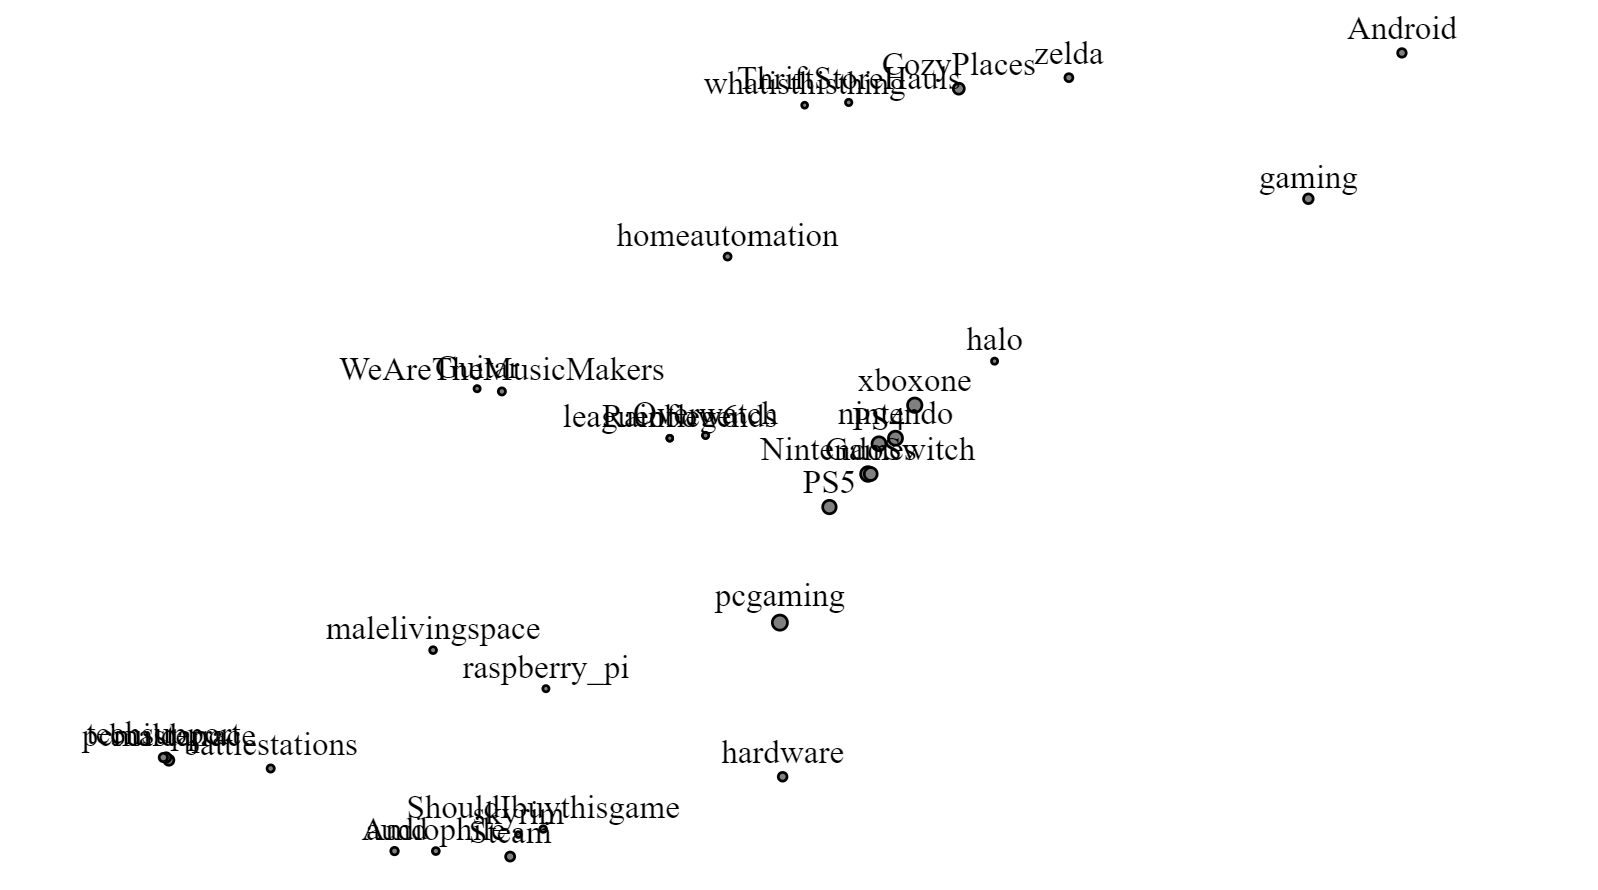

Here is another cluster :

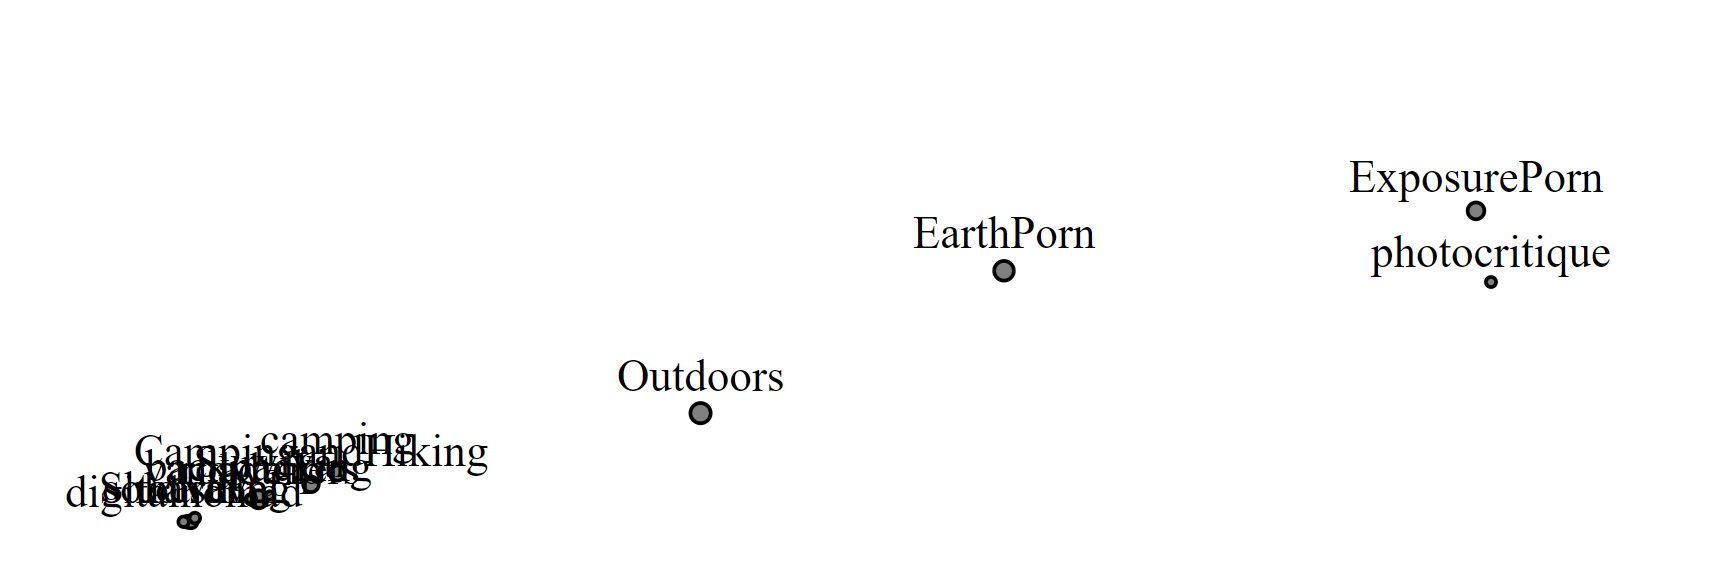

#### Clustering Algorithms and their applications to our network

In this section, we will implement 3 clustering alogithms and apply a pageRank on the labels.

In [ ]:
def page_Rank(labels,n_selection=10):
  pagerank = PageRank()
  selection = []
  for label in np.arange(len(set(labels))):
      ppr = pagerank.fit_transform(connected_adjacency, seeds=(labels==label))
      scores = ppr * (labels==label)
      selection.append(top_k(scores, n_selection))
  selection = np.array(selection)
  # show selection
  for label in np.arange(len(set(labels))-1):
      print('---')
      print(label)
      print(connected_names[selection[label]])

**Louvain algorithm :** is a scalable method built on Newman-Girvan algorithm. Its main idea is to maximize the modularity. It goes through two steps : in the first step, the algorithm goes over the nodes in the graph and adds each node to a cluster if it leads to an increase of modularity, in the second step, the algorithm groups nodes of a cluster into one node. These two steps repeat iteratively.

In [ ]:
#louvain algorithm for clustering
algo = Louvain()
labels_louvain = algo.fit_transform(connected_adjacency)
page_Rank(labels_louvain)

---
0
['technology' 'space' 'television' 'politics' 'worldnews' 'movies'
 'Economics' 'xboxone' 'pcgaming' 'apple']
---
1
['Damnthatsinteresting' 'nextfuckinglevel' 'interestingasfuck'
 'oddlysatisfying' 'therewasanattempt' 'Unexpected' 'MadeMeSmile'
 'facepalm' 'maybemaybemaybe' 'AbruptChaos']
---
2
['backpacking' 'AnimeART' 'pcmasterrace' 'CampingandHiking' 'AnimeSketch'
 'pics' 'solotravel' 'CozyPlaces' 'Art' 'camping']
---
3
['Nudes' 'BreedingMaterial' 'collegesluts' 'adorableporn' 'boobs' 'pussy'
 'Nude_Selfie' 'LegalTeens' 'bigasses' 'nsfw_gifs']
---
4
['dankmemes' 'meme' 'memes' 'wholesomememes' 'Animemes' 'manga'
 'marvelmemes' 'shitposting' 'BikiniBottomTwitter' 'reactiongifs']
---
5
['dating_advice' 'dating' 'relationship_advice' 'NoStupidQuestions'
 'AskMen' 'relationships' 'AskWomen' 'pettyrevenge' 'TooAfraidToAsk'
 'MaliciousCompliance']
---
6
['EatCheapAndHealthy' 'nutrition' 'Cooking' 'HealthyFood'
 'bodyweightfitness' 'loseit' 'FoodPorn' 'food' 'SkincareAddiction'
 'run

We found some really interesting clusters with Louvain and Page Rank Algorithms. 

**Label propagation :** is an algorithm that begins by assigning each node a labe, then iteratively simulates a process where a node is given the most common label among its closest nodes. this process is repeated until the label of each nodes is that of the maximum occuring one among its neighbors.

In [ ]:
propagation = PropagationClustering()
labels_propag = propagation.fit_transform(connected_adjacency)
page_Rank(labels_propag)

---
0
['pcgaming' 'xboxone' 'NintendoSwitch' 'PS4' 'nintendo' 'EDM' 'anime'
 'Steam' 'manga' 'ShouldIbuythisgame']
---
1
['HomeImprovement' 'DIY' 'woodworking' 'homeautomation' 'howto' 'rpg'
 'boardgames' 'funny' 'terriblefacebookmemes' 'TittyDrop']
---
2
['technology' 'space' 'politics' 'worldnews' 'television' 'Economics'
 'movies' 'apple' 'books' 'UpliftingNews']
---
3
['loseit' 'bodyweightfitness' 'progresspics' 'Fitness' 'funny'
 'terriblefacebookmemes' 'TittyDrop' 'comics' 'Survival' 'trees']
---
4
['Overwatch' 'leagueoflegends' 'Rainbow6' 'funny' 'google'
 'terriblefacebookmemes' 'TittyDrop' 'comics' 'Survival' 'trees']
---
5
['pcmasterrace' 'buildapc' 'techsupport' 'battlestations' 'audiophile'
 'malelivingspace' 'Amd' 'raspberry_pi' 'entitledparents' 'adorableporn']
---
6
['interestingasfuck' 'Damnthatsinteresting' 'nextfuckinglevel'
 'oddlysatisfying' 'therewasanattempt' 'Unexpected' 'MadeMeSmile'
 'BeAmazed' 'facepalm' 'KidsAreFuckingStupid']
---
7
['dating_advice' 'dating' 

**K-means algorithm :** separates the network into k clusters based on the location of the nodes such that their distance of the centroid is minimized. The distance is chosen using different metrics. The most common one is the euclidean distance

In [ ]:
kmeans = KMeans(n_clusters= 9)
labels_kmeans = kmeans.fit_transform(connected_adjacency)
page_Rank(labels_kmeans)

---
0
['Damnthatsinteresting' 'interestingasfuck' 'nextfuckinglevel'
 'oddlysatisfying' 'therewasanattempt' 'Unexpected' 'MadeMeSmile'
 'facepalm' 'KidsAreFuckingStupid' 'maybemaybemaybe']
---
1
['technology' 'space' 'politics' 'worldnews' 'Economics' 'apple'
 'listentothis' 'programming' 'UpliftingNews' 'science']
---
2
['dating_advice' 'dating' 'NoStupidQuestions' 'relationship_advice'
 'AskMen' 'Cooking' 'AskWomen' 'EatCheapAndHealthy' 'nutrition'
 'HealthyFood']
---
3
['xboxone' 'pcgaming' 'television' 'movies' 'NintendoSwitch' 'nintendo'
 'PS4' 'PS5' 'Marvel' 'marvelstudios']
---
4
['Nudes' 'BreedingMaterial' 'collegesluts' 'adorableporn' 'boobs' 'pussy'
 'Nude_Selfie' 'LegalTeens' 'bigasses' 'nsfw_gifs']
---
5
['AnimeART' 'AnimeSketch' 'Art' 'drawing' 'somethingimade'
 'HomeImprovement' 'DIY' 'crafts' 'woodworking' 'homeautomation']
---
6
['stocks' 'pcmasterrace' 'investing' 'StockMarket' 'buildapc'
 'CryptoCurrency' 'Bitcoin' 'ethereum' 'ethtrader' 'techsupport']
---
7
['backpac

#### Cluster quality metrics and evaluation of the performance of the previous clustering algorithms

**Modularity** : Modularity is the fraction of edges that are in given communities minus the fraction if edges were distributed in a random graph.It is a scalar value between -1 and 1. Modularity has been shown to have a resolution limit. However, it is used to measure the strength of division of a networks into clusters.

In [ ]:
print("Modularity for Louvain Algorithm : ",np.round(modularity(connected_adjacency, labels_louvain), 2))
print("Modularity for label propagation Algorithm : ",np.round(modularity(connected_adjacency, labels_propag), 2))
print("Modularity for K-means Algorithm : ",np.round(modularity(connected_adjacency, labels_kmeans), 2))

Modularity for Louvain Algorithm :  0.57
Modularity for label propagation Algorithm :  0.5
Modularity for K-means Algorithm :  0.56


**Normalized standard deviation (STE):** is the normalized standard deviation of cluster sizes. A score of 1 means perfectly balanced clustering.

In [ ]:
print("STE for Louvain Algorithm : ",normalized_std(labels_louvain))
print("STE for label propagation Algorithm : ", normalized_std(labels_propag))
print("STE for KMeans Algorithm : ", normalized_std(labels_kmeans))

STE for Louvain Algorithm :  0.6916620732058367
STE for label propagation Algorithm :  0.44776725872918
STE for KMeans Algorithm :  0.7264901534879802


Based on the metrics above, label propagation underperforms compared to the other methods, which is something we expected by looking at the clusters.
Louvain algorithm has the highest modularity but it is less balanced than KMeans according to the STE metric. Consequently, the choice only depends the motive of the clustering, that is if we prefer more balanced or more precise clusters.

While flat clustering yields interesting results, these are not satisfactory enough because smaller subreddits on reddits could be considered as branches of bigger ones. For example flat clustering considers AbandonedPorn, urbanexploration and pics to be in the same cluster, However, it doesn't perfectly maje sense because the two first are sub-genres of the third which is something hierarchal clustering takes into consideration.

This is why we decided to use hierarchal clustering algorithms.

#### Hierarchal Clustering Algorithms and their applications to our network

**Paris algorithm:** is a graph clustering algorithm using Node Pair Sampling. It is an agglomerative clustering algorithm that performs greedy merge of nodes based on their similarity. The output of the algorithm is a regular dendrogram.



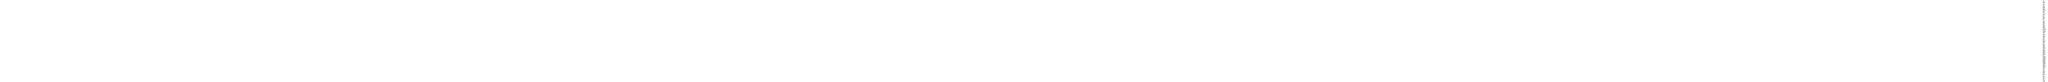

In [ ]:
paris = Paris()
dendrogram_Paris = paris.fit_transform(connected_adjacency)
image = svg_dendrogram(dendrogram_Paris, names=connected_names, rotate=True, width=100000, height=4000)
SVG(image)

**Hierarchal Louvain algorithm:** performs hierarchal clustering by instanciating successively the Louvain algorithm from top to down.

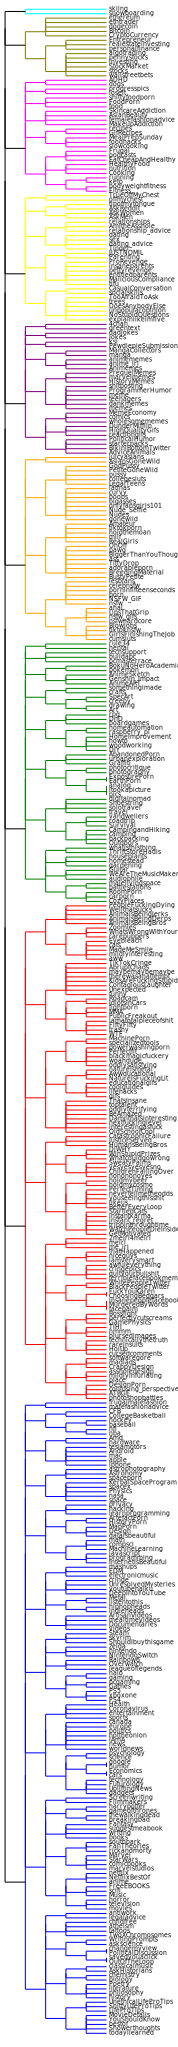

In [ ]:
louvain = LouvainHierarchy(depth=10)
dendrogram_Louvain = louvain.fit_transform(connected_adjacency)
image = svg_dendrogram(dendrogram_Louvain, names=connected_names, rotate=True, width=200, height=4000)
SVG(image)

**Clustering by the ward method :** is a general agglomerative hierarchical clustering procedure, where the criterion for choosing the pair of clusters to merge at each step is based on the optimal value of an objective function.

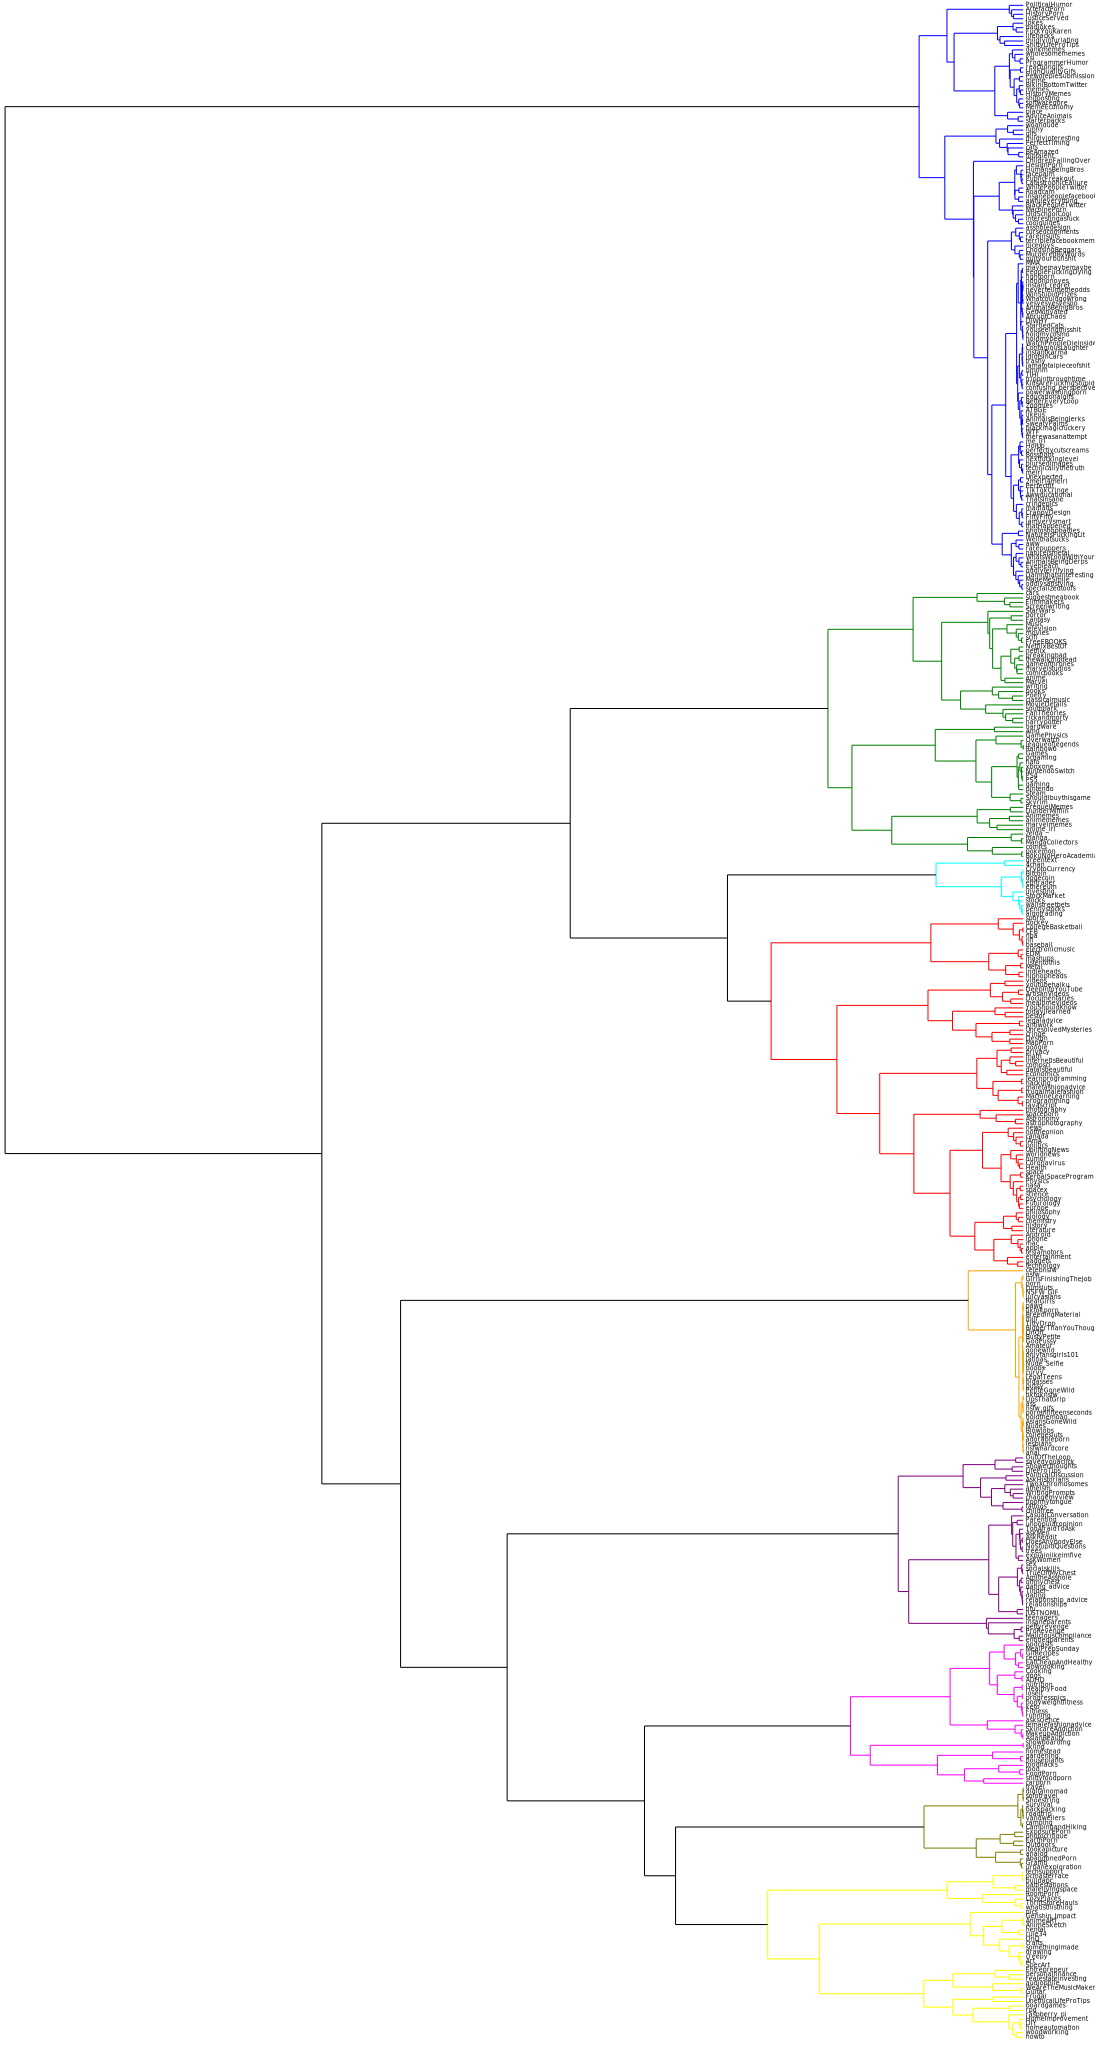

In [ ]:
ward = Ward()
dendrogram_Ward = ward.fit_transform(connected_adjacency)
image = svg_dendrogram(dendrogram_Ward, names=connected_names, n_clusters=9, rotate=True, width=2000, height=4000)
SVG(image)

####  Hierarchal clustering quality metrics and evaluation of the performance of the previous clustering algorithms

**Dasgupta’s score** is an unsupervised measure of the quality of a hierarchical clustering of an edge weighted graph. It is defined as 1 - normalized Dasgupta’s cost. It is between 0 and 1.

**Dasgupta’s cost** Let $ T $ be a tree representing a hierarchical clustering of the graph $ G=(V,E) $. Let $ w $ be a dissimilarity function on the edges $ E $ of the graph.

The Dasgupta’s cost is defined as:

$$ \textrm{dasgupta}(T,V,E,w) = \sum_{{x,y}∈E} \frac{\textrm{area}(lca_T(x,y))}{w({x,y})} $$



In [ ]:
print("Dasgupta score for Paris algorithm", round(dasgupta_score(connected_adjacency, dendrogram_Paris),3))
print("Dasgupta score for Louvain algorithm",round(dasgupta_score(connected_adjacency, dendrogram_Louvain),3))
print("Dasgupta score for Ward algorithm", round(dasgupta_score(connected_adjacency, dendrogram_Ward),3))

Dasgupta score for Paris algorithm 0.843
Dasgupta score for Louvain algorithm 0.842
Dasgupta score for Ward algorithm 0.842


**Tree sampling divergence TSD :** is an information-theoretic metric for assessing the quality of the hierarchical clustering of a graph. The TSD is the Kullback-Leibler divergence between two probability distributions over the nodes of this tree: those induced respectively by sampling at random edges and node pairs of the graph.

**It quantifies the ability to reconstruct the graph from the tree in terms of information loss.** In particular, the TSD is maximum when perfect reconstruction is feasible


In [ ]:
print("TSD score for Paris algorithm", tree_sampling_divergence(connected_adjacency, dendrogram_Paris))
print("TSD score for Louvain algorithm", tree_sampling_divergence(connected_adjacency, dendrogram_Louvain))
print("TSD score for Ward algorithm", tree_sampling_divergence(connected_adjacency, dendrogram_Ward))

TSD score for Paris algorithm 0.6326529442863706
TSD score for Louvain algorithm 0.6071926591791957
TSD score for Ward algorithm 0.5895296518220524


According to the results, the three hierarchal algorithms give similar Dasgupta cost with Paris having the highest one.

If we look at the visualizations, the Louvain hierarchal algorithm dendrogram is the easiest to observe and navigate because it does not represent a distance relative to how close the nodes are, plus, the depth is constant. However, its TSD score is consequently low because its uniform divison makes it harder to reconstruct the real network.

For the Paris one, the visualization is much more complex and we had to set a high width in order to observe the third layer because the first two clusters were so different from each other therefore the distance was very high. However, its TSD score is the highest because it's the closest to the real network.

The ward algorithm underperformed compared to the two others.

We decided to choose the Paris algorithm because we think that the fact that its dendrogram helps reconstruct the network the best is what we need in order to recommend communities because the results will be most likely closer to reality.

For our recommendation system, we can take the 5 closest subreddits to a given subreddit given by the Paris function. You can find the code below.

In [ ]:
from sknetwork.hierarchy import cut_straight
def recommendation(subreddit,dendrogram, names):
  index = np.where(names == subreddit)
  labels = cut_straight(dendrogram,n_clusters=250)
  label = labels[index]
  recommendation_list = []
  for i in range(len(connected_names)):
    if labels[i] == label :
      recommendation_list.append(names[i])
  recommendation_list.remove(subreddit)
  print(f'If you are a fan of {subreddit}, you might also like this list of subreddits : \n {recommendation_list}')

recommendation("halo",dendrogram_Paris, connected_names)

If you are a fan of halo, you might also like this list of subreddits : 
 ['gaming', 'leagueoflegends', 'Overwatch', 'xboxone', 'GamePhysics', 'Rainbow6']


The recommendation works! For example, halo is a video-game that can be played on the Xbox console. The recommendations were of other games (League of legends, Overwatch, Rainbox 6 siege) but also of gaming in general (gamung, GamePhysics, xboxone)

**To test the function for other subreddits, please replace "halo" by a subreddit name of choice (among our list of subreddits).**